# Notes

Dataset – "Young People Survey" by Miroslav Sabo: https://www.kaggle.com/miroslavsabo/young-people-survey

Link to Data Science Union @UCLA's Cleaned Dataset: https://github.com/the-data-science-union/DSU-W21-Personality/blob/main/cleaned_youngpeople_data.csv

# Importing Packages

In [1]:
# Everything we need to get started
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

# For feature selection
from sklearn.feature_selection import RFE

# For hyperparameter tuning
from pprint import pprint
from sklearn.model_selection import GridSearchCV

# For model evaluation
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Useful Functions

In [2]:
# We will be using this link to access a cleaned version of the Young People Survey by Data Science Union
csvname='https://raw.githubusercontent.com/the-data-science-union/DSU-W21-Personality/main/cleaned_youngpeople_data.csv'

# Loads the entire dataset into X, y
# y includes all six potential response variables
# This function is no longer used...
def load_data(csvname=csvname):
    print('CSV File Path:', csvname)
    df = pd.read_csv(csvname)
    X = df.drop('Education', axis=1)
    y = df['Education'].copy()
    print('Dataset Loaded')
    return X, y

# Loads dataset, but y is transformed into 0s and 1s based on the target response variable
# This is the function we currently use for our dataset and model
def load_binary_data(csvname=csvname, response='secondary school'):
    print('CSV File Path:', csvname)
    df = pd.read_csv(csvname)
    X = df.drop('Education', axis=1)
    print('\nPotential Response Variables:', df['Education'].unique().tolist())
    print('\nSelected Response Variable:', response)
    df.loc[df['Education'] != response, 'Education'] = 0
    df.loc[df['Education'] == response, 'Education'] = 1
    y = df['Education'].copy()
    y = y.astype('int')
    return X, y, df

# Loads the dataset but drops two potential responses, this was an early attempt at combatting class imbalances
# Decided to stop using this function as class imbalance was still a major issue
def load_drop_data(csvname=csvname):  
    print('CSV File Path:', csvname)
    df = pd.read_csv(csvname)
    d_df = df[(df['Education'] != 'currently a primary school pupil') & (df['Education'] != 'doctorate degree')]
    X = d_df.drop('Education', axis=1)
    y = d_df['Education'].copy()
    print('Dataset Loaded')
    return X, y

# Returns a list of the names of the categorical predictors in the dataset
def find_categorical(X):
    catdf = X.loc[:, ~X.columns.isin(X._get_numeric_data().columns)]
    return catdf.columns.values.tolist()

# Sets up a base-line Random Forest for on-the-go evaluation
# Has an optional parameter to plot the model's confusion matrix or only return accuracy score
def quick_forest(select_x, y, plot=True, score=False):
    X_train, X_test, y_train, y_test = train_test_split(select_x, y, test_size=0.3)
    qf = RandomForestClassifier()
    qf.fit(X_train, y_train)
    if score:
        return qf.score(X_test, y_test)
    print('Accuracy Score:', qf.score(X_test, y_test))
    if plot:
        plot_confusion_matrix(qf, X_test, y_test)

# Loading in and Preparing our DataFrame

We start by loading in our data. We obtained this data from Miroslav Sabos' Young People Survey from Kaggle, but we are using a version of it that we (Data Science Union @UCLA) already cleaned. 

The load_binary_data function will load in our data but converts the 'Education' column in our DataFrame from a multi-class categorical variable to a binary variable in order to avoid difficulties with class imbalances. We selected our response variable to be 'secondary school' because it is the mode of the column. In case we need to investigate anything further in our dataset, we also retain a copy of the original DataFrame.

In [3]:
X, y, df = load_binary_data(response='secondary school')
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

print('\nValue Counts of Response Variable:')
print(y.value_counts())

CSV File Path: https://raw.githubusercontent.com/the-data-science-union/DSU-W21-Personality/main/cleaned_youngpeople_data.csv

Potential Response Variables: ['college/bachelor degree', 'secondary school', 'primary school', 'masters degree', 'doctorate degree', 'currently a primary school pupil']

Selected Response Variable: secondary school
Shape of X: (977, 149)
Shape of y: (977,)

Value Counts of Response Variable:
1    603
0    374
Name: Education, dtype: int64


Because scikit-learn's RandomForestClassifier cannot evalute non-binary categorical nominal data, we are going to find the categorical variables in the DataFrame and convert them to binary datatypes using pandas.get_dummies().

In [4]:
cats = find_categorical(X)
print('Number of Categorical Variables:', len(cats))
print('\nCategoricals:', cats)

X_enc = pd.get_dummies(X, columns=cats)

Number of Categorical Variables: 10

Categoricals: ['Smoking', 'Alcohol', 'Punctuality', 'Lying', 'Internet usage', 'Gender', 'Left - right handed', 'Only child', 'Village - town', 'House - block of flats']


# Baseline RandomForestClassifier

First, let's get a baseline score of the RandomForestClassifier's ability to predict whether a respondent's highest educational attainment is secondary school (high school) or not. It seems like our baseline model has a ~65% accuracy rate, but we have seen it get incredibly high accuracy scores on occasion by random chance.

Accuracy Score: 0.6564625850340136


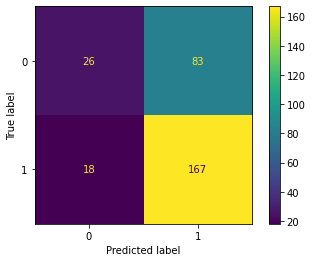

In [5]:
quick_forest(X_enc, y, plot=True)

# Feature Selection with RFE

Although Random Forests tend to produce reasonable predictions given a large volume of data, we will try Recursive Feature Elimination to hone our accuracy before moving on to hyperparameter tuning.

In [6]:
feature_groups = list()
rf = RandomForestClassifier()
for i in range(10, 20):
    selector = RFE(rf, n_features_to_select=i, step=1)
    selector.fit(X_enc, y)
    X_RFE = X_enc.loc[:, selector.support_]
    print('\n# of Features:', i)
    feats = X_RFE.columns.values.tolist()
    print(feats)
    feature_groups.append(feats)


# of Features: 10
['History', 'Biology', 'Art exhibitions', 'Adrenaline sports', 'Cheating in school', 'Changing the past', 'Entertainment spending', 'Age', 'Height', 'Weight']

# of Features: 11
['Rock n roll', 'War', 'History', 'Biology', 'Art exhibitions', 'Adrenaline sports', 'Workaholism', 'Entertainment spending', 'Age', 'Height', 'Weight']

# of Features: 12
['Classical music', 'War', 'History', 'Biology', 'Art exhibitions', 'Adrenaline sports', 'Changing the past', 'Life struggles', 'Entertainment spending', 'Age', 'Height', 'Weight']

# of Features: 13
['Dance', 'Alternative', 'History', 'Art exhibitions', 'Adrenaline sports', 'Prioritising workload', 'Cheating in school', 'Changing the past', 'Responding to a serious letter', 'Entertainment spending', 'Age', 'Height', 'Weight']

# of Features: 14
['Sci-fi', 'History', 'Biology', 'Cars', 'Art exhibitions', 'Theatre', 'Adrenaline sports', 'Writing notes', 'Workaholism', 'New environment', 'Entertainment spending', 'Age', 'Heig

In [7]:
trials = 50
rfe_scores = dict()

print('Number of Trials:', trials)

base_scores = [quick_forest(X_enc, y, score=True) for i in range(trials)]
# print(("\nBaseline Accuracy: ["+', '.join(['%.3f']*trials)+"]") % tuple(base_scores))
print('Baseline Mean Accuracy:', np.mean(base_scores))
print('Baseline Std:', np.std(base_scores))
print('–'*25)

for cols in feature_groups:
    test_rfe = X_enc.loc[:, cols]
    test_scores = [quick_forest(test_rfe, y, score=True) for i in range(trials)]
    print('\nNumber of Features:', len(cols))
#     print(("Accuracy Scores: ["+', '.join(['%.3f']*trials)+"]") % tuple(test_scores))
    print('Mean Accuracy:', np.mean(test_scores))
    print('Std:', np.std(test_scores))
    rfe_scores[np.mean(test_scores)] = cols

Number of Trials: 50
Baseline Mean Accuracy: 0.6651700680272108
Baseline Std: 0.025454906052101975
–––––––––––––––––––––––––

Number of Features: 10
Mean Accuracy: 0.6839455782312927
Std: 0.01973774091431374

Number of Features: 11
Mean Accuracy: 0.6820408163265307
Std: 0.02588826434027753

Number of Features: 12
Mean Accuracy: 0.6923809523809524
Std: 0.021653179839000117

Number of Features: 13
Mean Accuracy: 0.6860544217687076
Std: 0.02468975434552315

Number of Features: 14
Mean Accuracy: 0.6947619047619048
Std: 0.020039874176005786

Number of Features: 15
Mean Accuracy: 0.6864625850340136
Std: 0.023884139641795837

Number of Features: 16
Mean Accuracy: 0.7004761904761904
Std: 0.026288886584817685

Number of Features: 17
Mean Accuracy: 0.6829251700680272
Std: 0.022171966403997663

Number of Features: 18
Mean Accuracy: 0.7024489795918367
Std: 0.02208779741342116

Number of Features: 19
Mean Accuracy: 0.6931972789115646
Std: 0.024338154857140578


In [13]:
best_rfe_score = np.max(list(rfe_scores.keys()))
best_rfe_feats = rfe_scores[np.max(list(rfe_scores.keys()))]
print('Mean Score of {} Trials for {} Selected Features: {}\n'.format(trials, len(best_rfe_feats), best_rfe_score))
print(best_rfe_feats)

Mean Score of 50 Trials for 18 Selected Features: 0.7024489795918367

['Dance', 'Classical music', 'Alternative', 'War', 'History', 'Biology', 'Cars', 'Art exhibitions', 'Passive sport', 'Adrenaline sports', 'Elections', 'Cheating in school', 'Charity', 'New environment', 'Getting up', 'Age', 'Height', 'Weight']


# Hyperparameter Tuning

We will be using GridSearchCV to tune our hyperparameters, comparing the best parameters of the search with our baseline model score from before.

In [14]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(100, 251, 50)]
# Criterion for scoring
criterion = ['gini', 'entropy']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(4, 9, 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.arange(3, 6, 1)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
par_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
pprint(par_grid)

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [4, 5, 6, 7, 8, None],
 'min_samples_leaf': [1, 2, 3, 4, 5],
 'min_samples_split': [3, 4, 5],
 'n_estimators': [100, 150, 200, 250]}


In [16]:
selected_X = X_enc.loc[:, best_rfe_feats]
X_train, X_test, y_train, y_test = train_test_split(selected_X, y, test_size=0.3)
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = par_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [17]:
# Fit the Model...
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:  6.6min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, None],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [100, 150, 200, 250]},
             verbose=2)

In [18]:
# Let's look at our best parameters...
grid_search.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 200}

In [43]:
final_rf = RandomForestClassifier(bootstrap=True,
                                  criterion='entropy',
                                  max_depth=None,
                                  min_samples_leaf=4,
                                  min_samples_split=3,
                                  n_estimators=200)
print(final_rf)
final_rf.fit(X_train, y_train)
print('\nAccuracy Score:', final_rf.score(X_test, y_test))

RandomForestClassifier(criterion='entropy', min_samples_leaf=4,
                       min_samples_split=3, n_estimators=200)

Accuracy Score: 0.7210884353741497


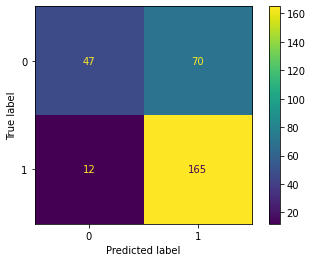

In [49]:
plot_confusion_matrix(final_rf, X_test, y_test)

In [47]:
cv = RepeatedKFold(n_splits=10, n_repeats=10)

# evaluate model
scores = cross_val_score(final_rf, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.672 (0.081)
